In [1]:
import pprint
import re
import string
import urllib.parse
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import requests_cache
import yaml
from curies import Converter
from dotenv import dotenv_values
from prefixmaps.io.parser import load_multi_context
from pymongo import MongoClient
from tqdm.notebook import tqdm

## ~ 6 minutes, 2025-03-08

In [2]:
def normalize_string(s):
    """
    Normalizes a string by lowercasing, trimming, and removing duplicate whitespace.
    """
    if not isinstance(s, str):
        return ""  # handle non string input.
    s = s.lower()
    s = s.strip()
    s = re.sub(r'\s+', ' ', s)  # Replace multiple whitespace with single space
    return s

In [3]:
def repair_curie(raw_curie: str) -> str:
    """
    Attempt to normalize or 'repair' the CURIE-like string:
      1. Normalize namespace to uppercase if it looks like 'ENVO'.
      2. Replace underscores or periods with a colon (':') between prefix & ID.
      3. Strip extra whitespace around the ID.
    """
    curie = raw_curie.strip()

    # Attempt to split at the first occurrence of [.:_]
    match = re.match(r'^([A-Za-z0-9]+)([\.:_])\s*(.*)$', curie) # todo not sensitive enough to the length and letter/number composition of prefix and local portion
    if not match:
        # If it doesn't match, just return the stripped version
        return curie

    prefix, sep, rest = match.groups()

    # Rebuild as prefix:rest with no extra spaces
    # todo repair should include normalizing the case of the prefix
    repaired = f"{prefix}:{rest.strip()}" # todo excessive replacement of underscores with colons in insensitive curies above
    return repaired

In [4]:
def extract_and_parse_env_triad_values(
        mongo_uri="mongodb://localhost:27017/",
        db_name="ncbi_metadata",
        input_collection_name="biosample_harmonized_attributes",
        output_collection_name="unique_triad_values"
):
    """
    Extracts unique values from 'env_broad_scale', 'env_local_scale', and 'env_medium' attributes
    from a MongoDB collection, counts their occurrences, and stores them in a new collection.
    Adds a progress indicator using estimated document count.

    :param mongo_uri: MongoDB connection URI.
    :param db_name: Name of the database.
    :param input_collection_name: Name of the input collection.
    :param output_collection_name: Name of the output collection.
    """

    try:
        client = MongoClient(mongo_uri)
        db = client[db_name]
        input_collection = db[input_collection_name]
        output_collection = db[output_collection_name]

        output_collection.drop()  # Drop the collection

        print(f"Collection '{output_collection_name}' dropped successfully.")

    except Exception as e:
        print(f"An error occurred: {e}")

    try:
        unique_values = {}

        estimated_count = input_collection.estimated_document_count()
        print(f"{estimated_count = }")

        with tqdm(total=estimated_count, desc="Processing Harmonized Biosamples") as pbar:
            for sample in input_collection.find():
                env_broad = sample.get("env_broad_scale")
                env_local = sample.get("env_local_scale")
                env_medium = sample.get("env_medium")

                for value in [env_broad, env_local, env_medium]:
                    if value:
                        if value in unique_values:
                            unique_values[value]["count"] += 1
                        else:
                            unique_values[value] = {"content": value, "count": 1}
                pbar.update(1)

        # Insert unique values into the new collection
        output_collection.insert_many(list(unique_values.values()))

        print(
            f"Extracted and counted unique environment attributes from '{input_collection_name}' to '{output_collection_name}'.")

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'client' in locals() and client:
            client.close()

In [5]:
def display_count_distribution(
        mongo_uri="mongodb://localhost:27017/",
        db_name="ncbi_metadata",
        input_collection_name="unique_triad_values"
):
    """
    Retrieves counts from a MongoDB collection and displays their distribution as a histogram.

    :param mongo_uri: MongoDB connection URI.
    :param db_name: Name of the database.
    :param input_collection_name: Name of the collection containing counts.
    """
    try:
        client = MongoClient(mongo_uri)
        db = client[db_name]
        collection = db[input_collection_name]

        counts = [doc["count"] for doc in collection.find({}, {"count": 1, "_id": 0})]  # get all counts

        if not counts:
            print("No counts found in the collection.")
            return

        plt.figure(figsize=(10, 6))
        plt.hist(counts, bins=np.logspace(np.log10(min(counts)), np.log10(max(counts)), 50),
                 log=True)  # use log scale and logspace for bins.
        plt.xscale('log')
        plt.title("Distribution of Counts")
        plt.xlabel("Count (log scale)")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'client' in locals() and client:
            client.close()



In [6]:
def assess_normalization_impact(
        mongo_uri="mongodb://localhost:27017/",
        db_name="ncbi_metadata",
        input_collection_name="unique_triad_values",
        fields_to_normalize=["content"]
):
    """
    Assesses the impact of string normalization on specified fields in a MongoDB collection.

    :param mongo_uri: MongoDB connection URI.
    :param db_name: Name of the database.
    :param input_collection_name: Name of the collection.
    :param fields_to_normalize: List of fields to normalize and assess.
    """
    try:
        client = MongoClient(mongo_uri)
        db = client[db_name]
        collection = db[input_collection_name]

        original_unique_counts = {}
        normalized_unique_counts = {}

        for field in fields_to_normalize:
            original_unique_values = set()
            normalized_unique_values = set()

            for doc in collection.find({field: {"$ne": None}}, {field: 1, "_id": 0}):
                original_value = doc.get(field)
                if isinstance(original_value, str):
                    original_unique_values.add(original_value)
                    normalized_value = normalize_string(original_value)
                    normalized_unique_values.add(normalized_value)

            original_unique_counts[field] = len(original_unique_values)
            normalized_unique_counts[field] = len(normalized_unique_values)

        print("Unique value counts before normalization:")
        for field, count in original_unique_counts.items():
            print(f"  {field}: {count}")

        print("\nUnique value counts after normalization:")
        for field, count in normalized_unique_counts.items():
            print(f"  {field}: {count}")

        print("\nReduction in unique values:")
        for field in fields_to_normalize:
            reduction = original_unique_counts[field] - normalized_unique_counts[field]
            percentage_reduction = (reduction / original_unique_counts[field]) * 100 if original_unique_counts[
                                                                                            field] > 0 else 0
            print(f"  {field}: {reduction} ({percentage_reduction:.2f}%)")

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'client' in locals() and client:
            client.close()


In [7]:
def find_envo_values(
        mongo_uri="mongodb://localhost:27017/",
        db_name="ncbi_metadata",
        input_collection_name="unique_triad_values"
):
    """
    Finds all content values containing "envo" (case-insensitive) in a MongoDB collection.

    :param mongo_uri: MongoDB connection URI.
    :param db_name: Name of the database.
    :param input_collection_name: Name of the collection.
    :return: A list of content values containing "envo".
    """
    try:
        client = MongoClient(mongo_uri)
        db = client[db_name]
        collection = db[input_collection_name]

        envo_values = []
        for doc in collection.find():
            content = doc.get("content", "")
            if "envo" in content.lower():
                envo_values.append(content)

        return envo_values

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'client' in locals() and client:
            client.close()


In [8]:
def dump_list_to_file(string_list, filename):
  """
  Dumps a list of strings to a text file, one item per line.

  Args:
    string_list: The list of strings to dump.
    filename: The name of the file to create or overwrite.
  """
  with open(filename, 'w') as f:
    for item in string_list:
      f.write(item + '\n')


In [9]:
def split_annotations(raw_content: str, obo_prefixes_lc: list, bioportal_prefixes_lc: list):
    """
    Split a single raw line into sub-annotations, returning a list of dicts:
      [
         {
           'raw_chunk': "...",         # substring after splitting
           'raw_curie': "...",         # curie as found in text (if any)
           'repaired_curie': "...",    # normalized curie (if any)
           'raw_label': "...",         # substring minus the matched curie portion
           'cleaned_label': "..."      # lowercased + extra whitespace removed
         },
         ...
      ]
    """
    # Split on major delimiters (pipe, semicolon, slash, comma)
    components = re.split(DELIMITERS, raw_content)

    results = []
    for component in components:
        component = component.strip()
        if not component:
            continue

        match = CURIE_PATTERN.search(component) # todo pattern is over-eager in detecting CURIes
        if match:
            raw_curie = match.group(1)
            repaired = repair_curie(raw_curie)

            # Remove the matched substring from the chunk to guess the label
            label_guess = component[:match.start()] + component[match.end():]
            # Also remove leftover brackets or parentheses
            label_guess = re.sub(r'[\(\)\[\]]+', ' ', label_guess).strip()

            cleaned_label = re.sub(f"[{re.escape(string.punctuation)}]", " ", label_guess.lower())
            cleaned_label = re.sub(f"\d+", " ", cleaned_label)
            cleaned_label = re.sub(r'\s+', ' ', cleaned_label.strip())

        else:
            # No curie found; treat entire chunk as label
            raw_curie = ''
            repaired = ''
            cleaned_label = re.sub(f"[{re.escape(string.punctuation)}]", " ", component.lower())
            cleaned_label = re.sub(f"\d+", " ", cleaned_label)
            cleaned_label = re.sub(r'\s+', ' ', cleaned_label.strip())
            label_guess = component

        repaired_prefix = repaired.split(":")[0]
        repaired_prefix_lc = repaired_prefix.lower()

        results.append({
            'raw_component': component,
            'raw_curie': raw_curie,
            'repaired_curie': repaired,
            'repaired_prefix': repaired_prefix,
            'obo_prefix': repaired_prefix_lc in obo_prefixes_lc,
            'bioportal_prefix': repaired_prefix_lc in bioportal_prefixes_lc,
            'raw_label': label_guess,
            'cleaned_label': cleaned_label,
            'cleaned_label_len': len(cleaned_label),
        })

    return results

In [10]:
# Function to get a random document by repaired prefix
# todo assumes presence of collection object
def get_random_by_repaired_prefix(prefix, input_collection_object):
    result = input_collection_object.aggregate([
        {"$match": {"parsed_annotations.repaired_prefix": prefix}},
        {"$sample": {"size": 1}}
    ])
    return list(result)  # Convert cursor to list for easy access


In [11]:
# Function to get a random document by annotations count
# todo assumes presence of collection object
def get_random_by_annotations_count(count, input_collection_object):
    result = input_collection_object.aggregate([
        {"$match": {"annotations_count": count}},
        {"$sample": {"size": 1}}
    ])
    return list(result)  # Convert cursor to list for easy access

In [12]:
# creating a collection of all values observed in any one of the triad fields, with biosample usage counts
extract_and_parse_env_triad_values(
        mongo_uri="mongodb://localhost:27017/",
        db_name="ncbi_metadata",
        input_collection_name="biosample_harmonized_attributes",
        output_collection_name="unique_triad_values"
)
# 6 minutes

Collection 'unique_triad_values' dropped successfully.
estimated_count = 43169967


Processing Harmonized Biosamples:   0%|          | 0/43169967 [00:00<?, ?it/s]

Extracted and counted unique environment attributes from 'biosample_harmonized_attributes' to 'unique_triad_values'.


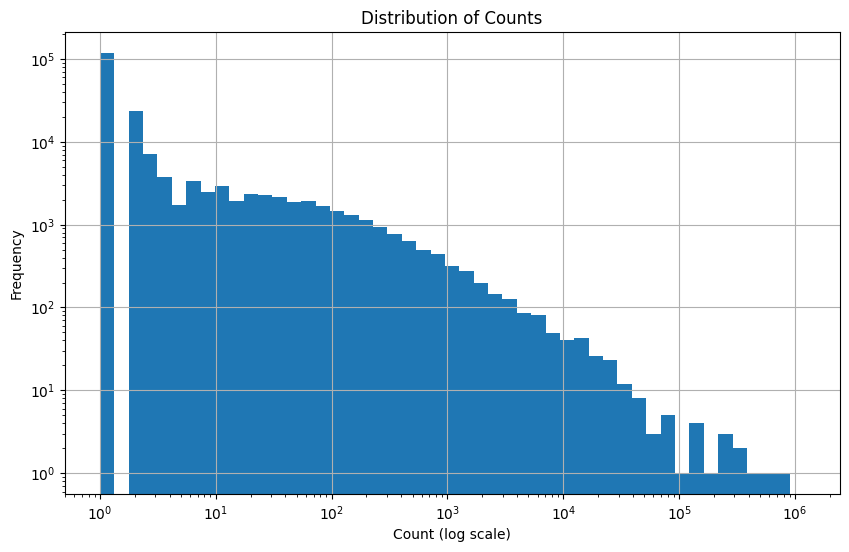

In [13]:
# Example usage (assuming MongoDB is running locally)
display_count_distribution(
        mongo_uri="mongodb://localhost:27017/",
        db_name="ncbi_metadata",
        input_collection_name="unique_triad_values"
)

## There are limits to the usefulness of premature normalization

In [14]:
# Example usage:
assess_normalization_impact(
    mongo_uri="mongodb://localhost:27017/",
    db_name="ncbi_metadata",
    input_collection_name="unique_triad_values",
    fields_to_normalize=["content"]
)

Unique value counts before normalization:
  content: 185144

Unique value counts after normalization:
  content: 178669

Reduction in unique values:
  content: 6475 (3.50%)


----

In [15]:
## For analyzing with LLMs etc.# Example usage:
envo_values = find_envo_values(
    mongo_uri="mongodb://localhost:27017/",
    db_name="ncbi_metadata",
    input_collection_name="unique_triad_values"
)

In [16]:
print(len(envo_values))

28091


In [17]:
triad_values_containing_envo_txt = "triad_values_containing_envo.txt"

In [18]:
dump_list_to_file(envo_values, triad_values_containing_envo_txt)

----

In [19]:
# load data about ontologies
# may come from other notebooks

In [20]:
obo_ontologies_tsv = "../../multi-lexmatch/obo_ontologies.tsv"
bioportal_ontology_class_counts_tsv = "../../multi-lexmatch/bioportal_ontology_class_counts.tsv"


In [21]:
obo_ontologies_frame = pd.read_csv(obo_ontologies_tsv, sep="\t")

In [22]:
obo_prefixes = set(obo_ontologies_frame['id']).union(set(obo_ontologies_frame['preferredPrefix']))
obo_prefixes_lc = {str(i).lower() for i in obo_prefixes}

In [23]:
bioportal_ontologies =  pd.read_csv(bioportal_ontology_class_counts_tsv, sep="\t")

In [24]:
bioportal_prefixes = set(bioportal_ontologies['acronym'])
bioportal_prefixes_lc = {i.lower() for i in bioportal_prefixes}

In [25]:
legit_prefixes_lc = list(obo_prefixes_lc.union(bioportal_prefixes_lc))
legit_prefixes_lc.sort()

----


In [26]:
# Regex to find potential CURIEs, optionally bracketed or parenthesized
# e.g., (ENVO:00000446), [EnvO_00005774], (envo.123456), etc.

# todo: over eager. doesn't take into consideration the typical length and character/number composition of real CURIes
CURIE_PATTERN = re.compile(
    r'[\(\[\s]*([A-Za-z0-9]+[\.:_]\s*[0-9A-Za-z]+)\s*[\)\]\s]*',
    flags=re.IGNORECASE
)

In [27]:
# We consider these delimiters for splitting multiple annotations in one value
DELIMITERS = r'[|;,/]+'

In [28]:
# Connect to local MongoDB on default port
client = MongoClient('mongodb://localhost:27017')


In [29]:
# Access the database and the collections
# use the connection builder from core.py>
db = client.ncbi_metadata
triad_values_collection = db.unique_triad_values


In [30]:
# For each document in unique_triad_values, parse and upsert into unique_triad_values

for doc in triad_values_collection.find():
    original_content = doc.get("content", "")
    parsed_annotations = split_annotations(original_content, obo_prefixes_lc=obo_prefixes_lc,
                                           bioportal_prefixes_lc=bioportal_prefixes_lc)

    # Create the update document
    new_doc = {
        "content_len": len(original_content),
        "formula_like": original_content.startswith("="),
        "parsed_annotations": parsed_annotations,
        "annotations_count": len(parsed_annotations),
    }

    # Upsert (update if exists, insert if not)
    triad_values_collection.update_one(
        {"_id": doc["_id"]},  # Match by original document ID
        {"$set": new_doc},  # Update fields
        upsert=True  # Insert if doesn't exist
    )

print("Upserted parsed triad annotations.")

# ~ 1 minute


Upserted parsed triad annotations.


In [31]:
# Ensure indexes exist for efficient querying
triad_values_collection.create_index([("annotations_count", 1)])
triad_values_collection.create_index([("content", 1)])
triad_values_collection.create_index([("content_len", 1)])
triad_values_collection.create_index([("count", 1)])
triad_values_collection.create_index([("formula_like", 1)])
triad_values_collection.create_index([("parsed_annotations.cleaned_label", 1)])
triad_values_collection.create_index([("parsed_annotations.cleaned_label_len", 1)])
triad_values_collection.create_index([("parsed_annotations.raw_component", 1)])
triad_values_collection.create_index([("parsed_annotations.raw_curie", 1)])
triad_values_collection.create_index([("parsed_annotations.raw_label", 1)])
triad_values_collection.create_index([("parsed_annotations.repaired_curie", 1)])
triad_values_collection.create_index([("parsed_annotations.repaired_prefix", 1)])

'parsed_annotations.repaired_prefix_1'

In [32]:
# todo check for presence in obo foundry registry yaml
# https://raw.githubusercontent.com/OBOFoundry/OBOFoundry.github.io/refs/heads/master/registry/ontologies.yml
# aka http://purl.obolibrary.org/meta/ontologies.yml
# parsed by notebooks/multi-lexmatch/parse_obo_ontologies_yaml.ipynb
# into notebooks/multi-lexmatch/obo_ontologies.tsv
# could also check analogous notebooks/multi-lexmatch/bioportal_ontology_class_counts.tsv

In [33]:
all_annotations = triad_values_collection.find({}, {"parsed_annotations.repaired_prefix": 1})

repaired_prefix_list = [
    annotation["repaired_prefix"]
    for doc in all_annotations
    for annotation in doc.get("parsed_annotations", [])
    if annotation["repaired_prefix"]  # Exclude empty values
]

prefix_counts = Counter(repaired_prefix_list)

# Convert to a DataFrame
prefix_count_frame = pd.DataFrame(prefix_counts.items(), columns=["repaired_prefix", "Count"])
prefix_count_frame = prefix_count_frame.sort_values(by="Count", ascending=False)


In [34]:
prefix_count_frame["obo_or_bioportal"] = prefix_count_frame["repaired_prefix"].str.lower().isin(legit_prefixes_lc)

some ontologies that we don't talk about frequently:
- bto brenda tissue ontology
- opl Ontology for Parasite LifeCycle
- pco Population and Community Ontology
- mmo measurement method ontology

In [35]:
prefix_count_frame

,repaired_prefix,Count,obo_or_bioportal
0,ENVO,35491,True
9,UBERON,2054,True
130,BTO,2024,True
271,sample,1796,False
5,PO,1381,True
...,...,...,...
5172,W25,1,False
19,Fallow,1,False
12,hydrothermal,1,False
7,rhizospheric,1,False


----

In [36]:
# Retrieve all annotation count values
all_counts = triad_values_collection.find({}, {"annotations_count": 1})

# Extract annotation counts into a list
annotation_count_list = [
    doc.get("annotations_count", 0) for doc in all_counts
]

# Count occurrences of each annotation count value
annotation_count_distribution = Counter(annotation_count_list)

# Convert to a DataFrame
annotation_count_frame = pd.DataFrame(
    annotation_count_distribution.items(), columns=["Annotations Count", "Frequency"]
)
annotation_count_frame = annotation_count_frame.sort_values(by="Annotations Count", ascending=True)

In [37]:
annotation_count_frame

,Annotations Count,Frequency
12,0,1
0,1,168601
1,2,6668
2,3,3810
4,4,2425
3,5,2590
5,6,299
7,7,26
10,8,7
13,9,1


In [38]:
random_prefix_sample = get_random_by_repaired_prefix("ENVO", input_collection_object=triad_values_collection)

In [39]:
random_prefix_sample

[{'_id': ObjectId('67cee5c793eed1680f80434e'),
  'content': 'ENVO:00002875 | ENVO:0000213',
  'count': 6,
  'annotations_count': 2,
  'content_len': 28,
  'formula_like': False,
  'parsed_annotations': [{'raw_component': 'ENVO:00002875',
    'raw_curie': 'ENVO:00002875',
    'repaired_curie': 'ENVO:00002875',
    'repaired_prefix': 'ENVO',
    'obo_prefix': True,
    'bioportal_prefix': True,
    'raw_label': '',
    'cleaned_label': '',
    'cleaned_label_len': 0},
   {'raw_component': 'ENVO:0000213',
    'raw_curie': 'ENVO:0000213',
    'repaired_curie': 'ENVO:0000213',
    'repaired_prefix': 'ENVO',
    'obo_prefix': True,
    'bioportal_prefix': True,
    'raw_label': '',
    'cleaned_label': '',
    'cleaned_label_len': 0}]}]

In [40]:
random_count_sample = get_random_by_annotations_count(3, input_collection_object=triad_values_collection)

In [41]:
random_count_sample

[{'_id': ObjectId('67cee5c893eed1680f81d6fc'),
  'content': '=IF(U190="Root", "root (PO:0025004)","shoot system (PO:0009013)")',
  'count': 2,
  'annotations_count': 3,
  'content_len': 65,
  'formula_like': True,
  'parsed_annotations': [{'raw_component': '=IF(U190="Root"',
    'raw_curie': '',
    'repaired_curie': '',
    'repaired_prefix': '',
    'obo_prefix': False,
    'bioportal_prefix': False,
    'raw_label': '=IF(U190="Root"',
    'cleaned_label': 'if u root',
    'cleaned_label_len': 9},
   {'raw_component': '"root (PO:0025004)"',
    'raw_curie': 'PO:0025004',
    'repaired_curie': 'PO:0025004',
    'repaired_prefix': 'PO',
    'obo_prefix': True,
    'bioportal_prefix': True,
    'raw_label': '"root"',
    'cleaned_label': 'root',
    'cleaned_label_len': 4},
   {'raw_component': '"shoot system (PO:0009013)")',
    'raw_curie': 'PO:0009013',
    'repaired_curie': 'PO:0009013',
    'repaired_prefix': 'PO',
    'obo_prefix': True,
    'bioportal_prefix': True,
    'raw_labe

In [42]:
# Retrieve all parsed annotations along with their counts
all_annotations = triad_values_collection.find({}, {"parsed_annotations.cleaned_label": 1, "count": 1})

# Dictionary to store cumulative counts for each cleaned_label
cleaned_label_counts = Counter()

# Iterate through each document and sum up counts per cleaned_label
for doc in all_annotations:
    doc_count = doc.get("count", 1)  # Default count to 1 if missing (to avoid KeyErrors)

    for annotation in doc.get("parsed_annotations", []):
        cleaned_label = annotation.get("cleaned_label")
        if cleaned_label:  # Ensure it's not empty
            cleaned_label_counts[cleaned_label] += doc_count  # Sum based on document count

In [43]:
# Convert Counter to a list of dictionaries
component_label_counts = [{"component_label": key, "count": count} for key, count in cleaned_label_counts.items()]

In [44]:
component_label_count_values = [i['count'] for i in component_label_counts]

In [45]:
triad_components_labels_collection = db.triad_components_labels

In [46]:
# Insert all records at once
if component_label_counts:
    triad_components_labels_collection.insert_many(component_label_counts)
    print("Inserted records successfully!")

Inserted records successfully!


In [47]:
# Ensure indexes exist for efficient querying
triad_components_labels_collection.create_index([("component_label", 1)])
triad_components_labels_collection.create_index([("count", 1)])

'count_1'

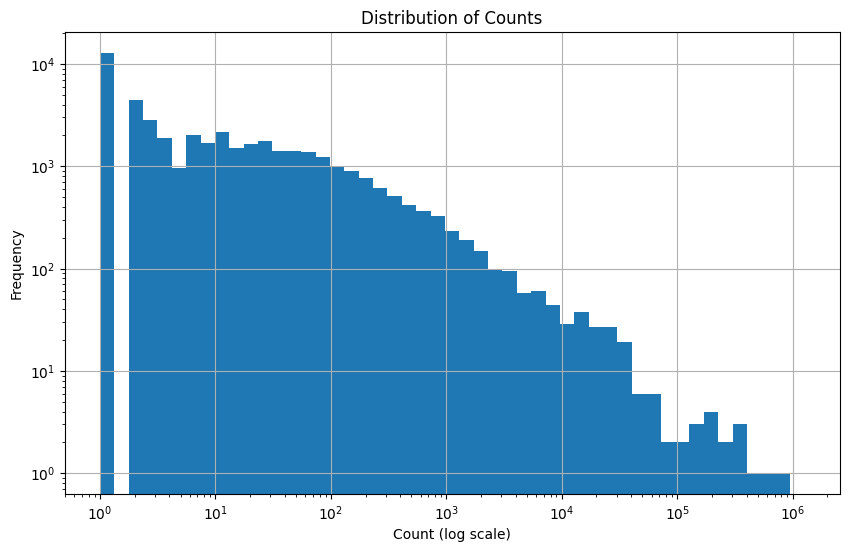

In [48]:
plt.figure(figsize=(10, 6))
plt.hist(component_label_count_values,
         bins=np.logspace(np.log10(min(component_label_count_values)), np.log10(max(component_label_count_values)), 50),
         log=True)  # use log scale and logspace for bins.
plt.xscale('log')
plt.title("Distribution of Counts")
plt.xlabel("Count (log scale)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [49]:
# Convert to a DataFrame
df_cleaned_label_counts = pd.DataFrame(cleaned_label_counts.items(), columns=["Cleaned Label", "Count"])
df_cleaned_label_counts = df_cleaned_label_counts.sort_values(by="Count", ascending=False)

In [50]:
df_cleaned_label_counts

,Cleaned Label,Count
140,not applicable,1264549
43,missing,840902
23,feces,607026
1,human associated habitat,471324
103,human gut,376855
...,...,...
7577,root canal scraping,1
7576,infected tooth root canal,1
7575,liver abcess material,1
7574,liver abcess,1
